In [2]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pickle
import glob
from __future__ import print_function, division
from music21 import converter, instrument, note, chord, stream
from keras.layers import Input, Dense, Reshape, Dropout, CuDNNLSTM, Bidirectional
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, RepeatVector, TimeDistributed
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils


In [3]:
def get_notes():

    notes = []
    for file in glob.glob("lofi_songs/*.mid"):
        try:
            midi = converter.parse(file)
        except:
            print('no time signature for '+ file)
            continue
        print(file)
        notes_to_parse = None
        s2 = instrument.partitionByInstrument(midi)
        notes_to_parse = s2.parts[0].recurse()
        for e in notes_to_parse:
            if isinstance(e, note.Note):
                notes.append(str(e.pitch))
            elif isinstance(e, chord.Chord):
                notes.append('.'.join(str(n) for n in e.normalOrder))
    
    return notes

In [4]:
def prepare_sequences(notes, n_vocab):

    sequence_length = 100

    pitchnames = sorted(set(item for item in notes))

    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))

    network_input = network_input / float(n_vocab)

    network_output = np_utils.to_categorical(network_output)

    return (network_input, network_output)

In [5]:
def create_midi(prediction_output, filename):

    offset = 0
    output_notes = []

    for item in prediction_output:
        pattern = item[0]
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        offset += 0.65

    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='{}.mid'.format(filename))

In [11]:
class GAN():
    def __init__(self, rows,notes):
        self.seq_length = rows
        self.seq_shape = (self.seq_length, 1)
        self.latent_dim = 1000
        self.disc_loss = []
        self.gen_loss =[]
        self.notes = notes
        self.n_vocab = len(set(notes))
        
        optimizer = Adam(0.0002, 0.5)

        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        self.generator = self.build_generator()
        
        z = Input(shape=(self.latent_dim,))
        generated_seq = self.generator(z)

        self.discriminator.trainable = False
        
        validity = self.discriminator(generated_seq)
        
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_discriminator(self):

        model = Sequential()
        model.add(CuDNNLSTM(512, input_shape=self.seq_shape, return_sequences=True))
        model.add(Bidirectional(CuDNNLSTM(512)))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        seq = Input(shape=self.seq_shape)
        validity = model(seq)

        return Model(seq, validity)
      
    def build_generator(self):
        

        model = Sequential()

#         WORKING MODEL - RNN-BASED GENERATOR
        
#         model.add(Dense(256, input_dim=self.latent_dim))
#         model.add(LeakyReLU(alpha=0.2))
#         model.add(BatchNormalization(momentum=0.8))
#         model.add(Dense(512))
#         model.add(LeakyReLU(alpha=0.2))
#         model.add(BatchNormalization(momentum=0.8))
#         model.add(Dense(1024))
#         model.add(LeakyReLU(alpha=0.2))
#         model.add(BatchNormalization(momentum=0.8))
#         model.add(Dense(np.prod(self.seq_shape), activation='tanh'))
#         model.add(Reshape(self.seq_shape))
#         model.summary()


#       WORKING MODEL - LSTM-BASED GENERATOR

        model.add(CuDNNLSTM(256, input_shape=(1000,1), return_sequences=True))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Bidirectional(CuDNNLSTM(512)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.seq_shape), activation='tanh'))
        model.add(Reshape(self.seq_shape))
        model.summary()
        
        noise = Input(shape=(self.latent_dim,))
        seq = model(noise)

        return Model(noise, seq)

    def train(self,notes, epochs, batch_size, sample_interval=50):

        notes = notes
        n_vocab = len(set(notes))
        X_train, y_train = prepare_sequences(notes, n_vocab)
        real = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            real_seqs = X_train[idx]
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_seqs = self.generator.predict(noise)

            d_loss_real = self.discriminator.train_on_batch(real_seqs, real)
            d_loss_fake = self.discriminator.train_on_batch(gen_seqs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            g_loss = self.combined.train_on_batch(noise, real)

            if epoch % sample_interval == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.disc_loss.append(d_loss[0])
                self.gen_loss.append(g_loss)

            if epoch % 10 == 0:    
                self.generator.save("Models/GAN_lofi_new3_2k.h5")
        return self.latent_dim, self.disc_loss, self.gen_loss
        
       
    def generate(self, input_notes):
        notes = input_notes
        n_vocab = len(set(notes))
        pitchnames = sorted(set(item for item in notes))
        int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
        
        noise = np.random.normal(0, 1, (1, self.latent_dim))
        predictions = self.generator.predict(noise)
        pred_notes = [((x+1)*(n_vocab)/2) for x in predictions[0]]
        pred_notes = [int_to_note[int(x)] for x in pred_notes]
        
        create_midi(pred_notes, 'gan_outputs/gan_output_lofi_new3_2k')
        
    def plot_loss(self):
        plt.plot(self.disc_loss, c='red')
        plt.plot(self.gen_loss, c='blue')
        plt.title("GAN Loss per Epoch")
        plt.legend(['Discriminator', 'Generator'])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.savefig('GraphsMetrics/GAN_Loss_per_Epoch_lofi_new3_2k.png', transparent=True)
        plt.close()

In [12]:

notes = get_notes()
n_notes = len(set(notes))
gan = GAN(rows=100,notes=notes)    
gan.train(notes = notes,epochs=2000, batch_size=64, sample_interval=1)

gan.generate(notes)
gan.plot_loss()

lofi_songs\1.mid
lofi_songs\10.mid
lofi_songs\11.mid
lofi_songs\12.mid
lofi_songs\13.mid
lofi_songs\14.mid
lofi_songs\15.mid
lofi_songs\16.mid
lofi_songs\17.mid
lofi_songs\18.mid
lofi_songs\19.mid
lofi_songs\2.mid
lofi_songs\20.mid
lofi_songs\3.mid
lofi_songs\4.mid
lofi_songs\5.mid
lofi_songs\6.mid
lofi_songs\7.mid
lofi_songs\8.mid
lofi_songs\9.mid
lofi_songs\Cymatics - Eternity MIDI 1 - C Maj.mid
lofi_songs\Cymatics - Eternity MIDI 10 - F Min.mid
lofi_songs\Cymatics - Eternity MIDI 11 - A Maj.mid
lofi_songs\Cymatics - Eternity MIDI 12 - A Min.mid
lofi_songs\Cymatics - Eternity MIDI 13 - A Min.mid
lofi_songs\Cymatics - Eternity MIDI 14 - A Min.mid
lofi_songs\Cymatics - Eternity MIDI 15 - A# Maj.mid
lofi_songs\Cymatics - Eternity MIDI 16 - A# Maj.mid
lofi_songs\Cymatics - Eternity MIDI 17 - A# Maj.mid
lofi_songs\Cymatics - Eternity MIDI 18 - A# Maj.mid
lofi_songs\Cymatics - Eternity MIDI 19 - A# Min.mid
lofi_songs\Cymatics - Eternity MIDI 2 - C# Min.mid
lofi_songs\Cymatics - Eternity MI

14 [D loss: 0.693595, acc.: 50.00%] [G loss: 0.794434]
15 [D loss: 0.688803, acc.: 52.34%] [G loss: 0.793246]
16 [D loss: 0.694223, acc.: 53.12%] [G loss: 0.783787]
17 [D loss: 0.701251, acc.: 50.00%] [G loss: 0.776600]
18 [D loss: 0.700175, acc.: 53.91%] [G loss: 0.796828]
19 [D loss: 0.699962, acc.: 53.12%] [G loss: 0.777542]
20 [D loss: 0.696679, acc.: 53.12%] [G loss: 0.784504]
21 [D loss: 0.696327, acc.: 53.91%] [G loss: 0.789178]
22 [D loss: 0.697552, acc.: 55.47%] [G loss: 0.797009]
23 [D loss: 0.669576, acc.: 62.50%] [G loss: 0.794244]
24 [D loss: 0.656130, acc.: 64.06%] [G loss: 0.834117]
25 [D loss: 0.661111, acc.: 62.50%] [G loss: 0.913307]
26 [D loss: 0.663841, acc.: 62.50%] [G loss: 0.955660]
27 [D loss: 0.649837, acc.: 60.16%] [G loss: 1.057899]
28 [D loss: 0.636992, acc.: 62.50%] [G loss: 1.220464]
29 [D loss: 0.663014, acc.: 57.81%] [G loss: 1.144297]
30 [D loss: 0.627317, acc.: 69.53%] [G loss: 1.197214]
31 [D loss: 0.599886, acc.: 67.97%] [G loss: 1.094396]
32 [D loss

128 [D loss: 0.541439, acc.: 67.97%] [G loss: 3.017823]
129 [D loss: 0.540075, acc.: 66.41%] [G loss: 3.213479]
130 [D loss: 0.289832, acc.: 97.66%] [G loss: 3.004528]
131 [D loss: 0.136093, acc.: 100.00%] [G loss: 2.919003]
132 [D loss: 0.102556, acc.: 100.00%] [G loss: 3.075702]
133 [D loss: 0.073707, acc.: 99.22%] [G loss: 3.043546]
134 [D loss: 0.059744, acc.: 98.44%] [G loss: 2.798048]
135 [D loss: 0.022656, acc.: 100.00%] [G loss: 2.434206]
136 [D loss: 0.029219, acc.: 100.00%] [G loss: 2.448757]
137 [D loss: 0.011318, acc.: 100.00%] [G loss: 2.809444]
138 [D loss: 0.026397, acc.: 99.22%] [G loss: 2.916631]
139 [D loss: 0.010957, acc.: 100.00%] [G loss: 2.401080]
140 [D loss: 0.057521, acc.: 98.44%] [G loss: 2.465413]
141 [D loss: 0.139398, acc.: 93.75%] [G loss: 3.400377]
142 [D loss: 0.886643, acc.: 55.47%] [G loss: 3.507820]
143 [D loss: 0.124059, acc.: 99.22%] [G loss: 3.482074]
144 [D loss: 0.127274, acc.: 99.22%] [G loss: 3.596983]
145 [D loss: 0.122308, acc.: 98.44%] [G lo

240 [D loss: 0.582094, acc.: 59.38%] [G loss: 2.084089]
241 [D loss: 0.381725, acc.: 85.16%] [G loss: 1.461373]
242 [D loss: 0.419971, acc.: 85.16%] [G loss: 1.019764]
243 [D loss: 0.279665, acc.: 85.16%] [G loss: 3.662574]
244 [D loss: 0.128463, acc.: 96.09%] [G loss: 1.535347]
245 [D loss: 0.334668, acc.: 86.72%] [G loss: 0.888982]
246 [D loss: 0.689052, acc.: 75.78%] [G loss: 1.315601]
247 [D loss: 0.416992, acc.: 81.25%] [G loss: 1.934293]
248 [D loss: 0.543104, acc.: 75.78%] [G loss: 1.330722]
249 [D loss: 0.390955, acc.: 85.16%] [G loss: 1.913095]
250 [D loss: 0.336061, acc.: 91.41%] [G loss: 1.009803]
251 [D loss: 0.495434, acc.: 78.12%] [G loss: 0.893457]
252 [D loss: 0.214046, acc.: 94.53%] [G loss: 6.295119]
253 [D loss: 0.179690, acc.: 95.31%] [G loss: 1.478993]
254 [D loss: 0.106281, acc.: 97.66%] [G loss: 2.774364]
255 [D loss: 0.124059, acc.: 94.53%] [G loss: 2.150802]
256 [D loss: 0.081398, acc.: 100.00%] [G loss: 2.919415]
257 [D loss: 0.062133, acc.: 98.44%] [G loss: 1

351 [D loss: 0.702739, acc.: 30.47%] [G loss: 0.798328]
352 [D loss: 0.709930, acc.: 28.12%] [G loss: 0.867099]
353 [D loss: 0.709222, acc.: 24.22%] [G loss: 0.882099]
354 [D loss: 0.713536, acc.: 21.09%] [G loss: 0.880560]
355 [D loss: 0.708094, acc.: 24.22%] [G loss: 0.855076]
356 [D loss: 0.708695, acc.: 15.62%] [G loss: 0.947584]
357 [D loss: 0.705530, acc.: 17.19%] [G loss: 0.990415]
358 [D loss: 0.707859, acc.: 17.97%] [G loss: 0.859706]
359 [D loss: 0.703511, acc.: 18.75%] [G loss: 0.845569]
360 [D loss: 0.706227, acc.: 20.31%] [G loss: 0.796747]
361 [D loss: 0.706384, acc.: 17.19%] [G loss: 0.838274]
362 [D loss: 0.690504, acc.: 18.75%] [G loss: 0.801510]
363 [D loss: 0.694233, acc.: 19.53%] [G loss: 0.749877]
364 [D loss: 0.707076, acc.: 14.84%] [G loss: 0.799588]
365 [D loss: 0.702436, acc.: 14.06%] [G loss: 0.796796]
366 [D loss: 0.697789, acc.: 18.75%] [G loss: 0.805890]
367 [D loss: 0.690784, acc.: 14.06%] [G loss: 0.816461]
368 [D loss: 0.678029, acc.: 15.62%] [G loss: 0.

464 [D loss: 0.682093, acc.: 46.09%] [G loss: 0.967245]
465 [D loss: 0.686851, acc.: 51.56%] [G loss: 0.855873]
466 [D loss: 0.678261, acc.: 45.31%] [G loss: 1.104484]
467 [D loss: 0.682733, acc.: 41.41%] [G loss: 0.852680]
468 [D loss: 0.677950, acc.: 49.22%] [G loss: 0.850242]
469 [D loss: 0.685803, acc.: 42.97%] [G loss: 0.841268]
470 [D loss: 0.692335, acc.: 54.69%] [G loss: 1.085141]
471 [D loss: 0.704030, acc.: 42.19%] [G loss: 1.141724]
472 [D loss: 0.699521, acc.: 49.22%] [G loss: 0.939612]
473 [D loss: 0.683490, acc.: 56.25%] [G loss: 1.056899]
474 [D loss: 0.584712, acc.: 53.12%] [G loss: 1.044008]
475 [D loss: 0.381650, acc.: 75.78%] [G loss: 0.857479]
476 [D loss: 0.383863, acc.: 88.28%] [G loss: 1.144661]
477 [D loss: 0.347775, acc.: 90.62%] [G loss: 0.940197]
478 [D loss: 0.622870, acc.: 71.88%] [G loss: 0.792788]
479 [D loss: 0.624765, acc.: 60.16%] [G loss: 0.910476]
480 [D loss: 0.588921, acc.: 66.41%] [G loss: 1.094537]
481 [D loss: 0.641472, acc.: 63.28%] [G loss: 1.

577 [D loss: 0.000280, acc.: 100.00%] [G loss: 1.849088]
578 [D loss: 0.000244, acc.: 100.00%] [G loss: 1.821474]
579 [D loss: 0.000244, acc.: 100.00%] [G loss: 2.165862]
580 [D loss: 0.000232, acc.: 100.00%] [G loss: 1.743273]
581 [D loss: 0.000211, acc.: 100.00%] [G loss: 1.965827]
582 [D loss: 0.000216, acc.: 100.00%] [G loss: 1.356182]
583 [D loss: 0.000201, acc.: 100.00%] [G loss: 1.674942]
584 [D loss: 0.000193, acc.: 100.00%] [G loss: 1.607119]
585 [D loss: 0.000194, acc.: 100.00%] [G loss: 1.750845]
586 [D loss: 0.000184, acc.: 100.00%] [G loss: 1.402323]
587 [D loss: 0.000205, acc.: 100.00%] [G loss: 1.558729]
588 [D loss: 0.000366, acc.: 100.00%] [G loss: 3.675851]
589 [D loss: 0.025835, acc.: 98.44%] [G loss: 7.526205]
590 [D loss: 0.001060, acc.: 100.00%] [G loss: 8.483841]
591 [D loss: 0.003550, acc.: 100.00%] [G loss: 7.675444]
592 [D loss: 0.003202, acc.: 100.00%] [G loss: 6.379713]
593 [D loss: 0.002182, acc.: 100.00%] [G loss: 4.863626]
594 [D loss: 0.001583, acc.: 100

690 [D loss: 0.693096, acc.: 24.22%] [G loss: 1.211921]
691 [D loss: 0.608672, acc.: 47.66%] [G loss: 5.287275]
692 [D loss: 5.184054, acc.: 0.78%] [G loss: 0.927630]
693 [D loss: 0.792971, acc.: 47.66%] [G loss: 1.199679]
694 [D loss: 0.862408, acc.: 0.78%] [G loss: 1.044296]
695 [D loss: 0.807249, acc.: 1.56%] [G loss: 0.898855]
696 [D loss: 0.770719, acc.: 0.78%] [G loss: 0.870242]
697 [D loss: 0.738387, acc.: 2.34%] [G loss: 0.816868]
698 [D loss: 0.742424, acc.: 0.78%] [G loss: 0.993509]
699 [D loss: 0.733732, acc.: 0.78%] [G loss: 0.821631]
700 [D loss: 0.706654, acc.: 3.91%] [G loss: 0.866676]
701 [D loss: 0.721837, acc.: 1.56%] [G loss: 0.804004]
702 [D loss: 0.722350, acc.: 0.78%] [G loss: 0.853461]
703 [D loss: 0.713314, acc.: 1.56%] [G loss: 0.859152]
704 [D loss: 0.717795, acc.: 0.78%] [G loss: 1.003262]
705 [D loss: 0.709466, acc.: 1.56%] [G loss: 0.817563]
706 [D loss: 0.719551, acc.: 0.00%] [G loss: 0.875119]
707 [D loss: 0.361828, acc.: 50.00%] [G loss: 1.792951]
708 [D

801 [D loss: 0.076988, acc.: 100.00%] [G loss: 2.109617]
802 [D loss: 0.080282, acc.: 99.22%] [G loss: 1.955564]
803 [D loss: 0.157736, acc.: 95.31%] [G loss: 2.034514]
804 [D loss: 0.318690, acc.: 87.50%] [G loss: 2.417933]
805 [D loss: 0.789817, acc.: 72.66%] [G loss: 1.064205]
806 [D loss: 0.507437, acc.: 73.44%] [G loss: 1.534613]
807 [D loss: 0.450157, acc.: 79.69%] [G loss: 3.531722]
808 [D loss: 2.254844, acc.: 9.38%] [G loss: 0.811107]
809 [D loss: 0.941949, acc.: 59.38%] [G loss: 0.827498]
810 [D loss: 0.665020, acc.: 57.03%] [G loss: 0.566535]
811 [D loss: 1.100218, acc.: 57.03%] [G loss: 0.955711]
812 [D loss: 0.754696, acc.: 54.69%] [G loss: 1.135456]
813 [D loss: 0.729519, acc.: 9.38%] [G loss: 1.010159]
814 [D loss: 0.763892, acc.: 3.91%] [G loss: 1.050406]
815 [D loss: 0.745040, acc.: 8.59%] [G loss: 1.050336]
816 [D loss: 0.713045, acc.: 5.47%] [G loss: 0.993328]
817 [D loss: 0.677361, acc.: 16.41%] [G loss: 1.218510]
818 [D loss: 0.707549, acc.: 55.47%] [G loss: 1.0889

914 [D loss: 0.583783, acc.: 68.75%] [G loss: 1.784343]
915 [D loss: 0.563562, acc.: 69.53%] [G loss: 1.553668]
916 [D loss: 0.561937, acc.: 72.66%] [G loss: 1.368867]
917 [D loss: 0.528853, acc.: 71.88%] [G loss: 1.581070]
918 [D loss: 0.594060, acc.: 67.19%] [G loss: 1.410549]
919 [D loss: 0.594385, acc.: 70.31%] [G loss: 1.631613]
920 [D loss: 0.540348, acc.: 73.44%] [G loss: 1.567132]
921 [D loss: 0.540247, acc.: 72.66%] [G loss: 1.804332]
922 [D loss: 0.571003, acc.: 69.53%] [G loss: 1.725752]
923 [D loss: 0.245219, acc.: 99.22%] [G loss: 1.954523]
924 [D loss: 0.292911, acc.: 97.66%] [G loss: 1.517363]
925 [D loss: 0.671982, acc.: 67.19%] [G loss: 1.147690]
926 [D loss: 0.496555, acc.: 76.56%] [G loss: 1.342907]
927 [D loss: 0.682361, acc.: 62.50%] [G loss: 1.328623]
928 [D loss: 0.633775, acc.: 63.28%] [G loss: 1.282576]
929 [D loss: 0.599359, acc.: 67.19%] [G loss: 1.242522]
930 [D loss: 0.254008, acc.: 100.00%] [G loss: 1.811632]
931 [D loss: 0.223215, acc.: 100.00%] [G loss: 

1027 [D loss: 0.590182, acc.: 72.66%] [G loss: 1.846287]
1028 [D loss: 0.930890, acc.: 50.00%] [G loss: 1.381349]
1029 [D loss: 0.767770, acc.: 50.00%] [G loss: 1.128159]
1030 [D loss: 0.695480, acc.: 10.16%] [G loss: 1.032169]
1031 [D loss: 0.623146, acc.: 64.06%] [G loss: 1.164361]
1032 [D loss: 0.698730, acc.: 55.47%] [G loss: 0.815132]
1033 [D loss: 0.706732, acc.: 53.91%] [G loss: 0.833895]
1034 [D loss: 0.700796, acc.: 54.69%] [G loss: 0.774344]
1035 [D loss: 0.704191, acc.: 52.34%] [G loss: 0.778094]
1036 [D loss: 0.701644, acc.: 51.56%] [G loss: 0.820895]
1037 [D loss: 0.673814, acc.: 50.00%] [G loss: 0.793072]
1038 [D loss: 0.697821, acc.: 51.56%] [G loss: 0.798569]
1039 [D loss: 0.669129, acc.: 53.12%] [G loss: 0.838412]
1040 [D loss: 0.672944, acc.: 55.47%] [G loss: 0.866780]
1041 [D loss: 0.660239, acc.: 58.59%] [G loss: 0.842004]
1042 [D loss: 0.681657, acc.: 53.91%] [G loss: 0.986256]
1043 [D loss: 0.652236, acc.: 57.03%] [G loss: 1.091210]
1044 [D loss: 0.688544, acc.: 5

1138 [D loss: 0.323708, acc.: 94.53%] [G loss: 3.368208]
1139 [D loss: 1.372436, acc.: 31.25%] [G loss: 1.677830]
1140 [D loss: 0.784208, acc.: 53.91%] [G loss: 1.744651]
1141 [D loss: 0.680561, acc.: 52.34%] [G loss: 1.663695]
1142 [D loss: 0.656313, acc.: 53.91%] [G loss: 2.225641]
1143 [D loss: 0.644471, acc.: 57.81%] [G loss: 2.099860]
1144 [D loss: 0.643957, acc.: 57.81%] [G loss: 1.980289]
1145 [D loss: 0.644177, acc.: 56.25%] [G loss: 2.102529]
1146 [D loss: 0.632954, acc.: 55.47%] [G loss: 2.635556]
1147 [D loss: 0.601873, acc.: 72.66%] [G loss: 2.269078]
1148 [D loss: 0.588935, acc.: 85.16%] [G loss: 2.467619]
1149 [D loss: 0.460720, acc.: 88.28%] [G loss: 2.699587]
1150 [D loss: 0.390208, acc.: 87.50%] [G loss: 2.858595]
1151 [D loss: 0.342315, acc.: 89.84%] [G loss: 2.835068]
1152 [D loss: 0.342690, acc.: 88.28%] [G loss: 2.883450]
1153 [D loss: 0.368631, acc.: 85.16%] [G loss: 2.734402]
1154 [D loss: 0.275625, acc.: 93.75%] [G loss: 2.923601]
1155 [D loss: 0.189631, acc.: 9

1249 [D loss: 0.381018, acc.: 86.72%] [G loss: 2.057950]
1250 [D loss: 0.451239, acc.: 84.38%] [G loss: 2.034866]
1251 [D loss: 0.492075, acc.: 75.78%] [G loss: 2.075540]
1252 [D loss: 0.433783, acc.: 82.03%] [G loss: 1.929366]
1253 [D loss: 0.521658, acc.: 71.09%] [G loss: 2.150499]
1254 [D loss: 0.445764, acc.: 76.56%] [G loss: 2.093368]
1255 [D loss: 0.449834, acc.: 78.91%] [G loss: 2.075889]
1256 [D loss: 0.532109, acc.: 71.09%] [G loss: 2.218087]
1257 [D loss: 0.484807, acc.: 75.78%] [G loss: 2.060738]
1258 [D loss: 0.565363, acc.: 72.66%] [G loss: 1.996776]
1259 [D loss: 0.519435, acc.: 75.00%] [G loss: 1.912096]
1260 [D loss: 0.455170, acc.: 79.69%] [G loss: 2.042033]
1261 [D loss: 0.522316, acc.: 74.22%] [G loss: 2.120756]
1262 [D loss: 0.545752, acc.: 75.78%] [G loss: 2.135437]
1263 [D loss: 0.622095, acc.: 73.44%] [G loss: 1.960065]
1264 [D loss: 0.733481, acc.: 59.38%] [G loss: 1.370546]
1265 [D loss: 0.495228, acc.: 72.66%] [G loss: 1.337059]
1266 [D loss: 0.579536, acc.: 6

1360 [D loss: 0.663066, acc.: 60.16%] [G loss: 1.155937]
1361 [D loss: 0.623459, acc.: 67.97%] [G loss: 1.195734]
1362 [D loss: 0.606648, acc.: 67.19%] [G loss: 1.095698]
1363 [D loss: 0.665867, acc.: 59.38%] [G loss: 1.200950]
1364 [D loss: 0.604044, acc.: 64.84%] [G loss: 1.446860]
1365 [D loss: 0.620797, acc.: 64.06%] [G loss: 1.327165]
1366 [D loss: 0.575824, acc.: 70.31%] [G loss: 1.202787]
1367 [D loss: 0.623293, acc.: 63.28%] [G loss: 1.210926]
1368 [D loss: 0.643897, acc.: 54.69%] [G loss: 1.219263]
1369 [D loss: 0.670994, acc.: 53.12%] [G loss: 1.443527]
1370 [D loss: 0.600717, acc.: 74.22%] [G loss: 1.486953]
1371 [D loss: 0.635537, acc.: 60.94%] [G loss: 1.286644]
1372 [D loss: 0.657504, acc.: 61.72%] [G loss: 1.006456]
1373 [D loss: 0.505156, acc.: 72.66%] [G loss: 1.172710]
1374 [D loss: 0.484536, acc.: 77.34%] [G loss: 1.010682]
1375 [D loss: 0.518553, acc.: 68.75%] [G loss: 1.355941]
1376 [D loss: 0.556085, acc.: 69.53%] [G loss: 1.062132]
1377 [D loss: 0.614502, acc.: 6

1471 [D loss: 0.656570, acc.: 58.59%] [G loss: 1.002702]
1472 [D loss: 0.685513, acc.: 55.47%] [G loss: 1.933440]
1473 [D loss: 0.671238, acc.: 59.38%] [G loss: 1.043889]
1474 [D loss: 0.668513, acc.: 53.91%] [G loss: 1.243117]
1475 [D loss: 0.707191, acc.: 48.44%] [G loss: 0.903039]
1476 [D loss: 0.659845, acc.: 60.16%] [G loss: 0.990689]
1477 [D loss: 0.676331, acc.: 53.12%] [G loss: 1.178444]
1478 [D loss: 0.672336, acc.: 53.91%] [G loss: 1.032291]
1479 [D loss: 0.663187, acc.: 52.34%] [G loss: 1.177221]
1480 [D loss: 0.683471, acc.: 46.09%] [G loss: 1.001342]
1481 [D loss: 0.657606, acc.: 53.91%] [G loss: 1.286088]
1482 [D loss: 0.677247, acc.: 53.12%] [G loss: 0.969124]
1483 [D loss: 0.684840, acc.: 53.91%] [G loss: 0.972302]
1484 [D loss: 0.682883, acc.: 55.47%] [G loss: 0.868625]
1485 [D loss: 0.673447, acc.: 50.78%] [G loss: 0.836769]
1486 [D loss: 0.658937, acc.: 57.03%] [G loss: 0.999759]
1487 [D loss: 0.677194, acc.: 53.12%] [G loss: 1.008143]
1488 [D loss: 0.676168, acc.: 5

1582 [D loss: 0.645408, acc.: 54.69%] [G loss: 1.199654]
1583 [D loss: 0.611116, acc.: 66.41%] [G loss: 1.454895]
1584 [D loss: 0.700734, acc.: 50.78%] [G loss: 1.507036]
1585 [D loss: 0.627065, acc.: 58.59%] [G loss: 1.437363]
1586 [D loss: 0.644741, acc.: 53.12%] [G loss: 1.369269]
1587 [D loss: 0.605246, acc.: 60.16%] [G loss: 1.230196]
1588 [D loss: 0.641547, acc.: 60.16%] [G loss: 1.398940]
1589 [D loss: 0.643275, acc.: 60.16%] [G loss: 1.406677]
1590 [D loss: 0.640601, acc.: 60.16%] [G loss: 1.259237]
1591 [D loss: 0.609739, acc.: 65.62%] [G loss: 1.486522]
1592 [D loss: 0.598231, acc.: 66.41%] [G loss: 1.388386]
1593 [D loss: 0.556287, acc.: 73.44%] [G loss: 1.489716]
1594 [D loss: 0.667926, acc.: 61.72%] [G loss: 1.489079]
1595 [D loss: 0.730307, acc.: 48.44%] [G loss: 1.443658]
1596 [D loss: 0.721671, acc.: 44.53%] [G loss: 1.166060]
1597 [D loss: 0.623950, acc.: 62.50%] [G loss: 1.149960]
1598 [D loss: 0.676770, acc.: 54.69%] [G loss: 1.414749]
1599 [D loss: 0.611111, acc.: 6

1693 [D loss: 0.613583, acc.: 64.06%] [G loss: 1.133518]
1694 [D loss: 0.667695, acc.: 56.25%] [G loss: 1.159869]
1695 [D loss: 0.681649, acc.: 53.91%] [G loss: 2.014822]
1696 [D loss: 0.642726, acc.: 60.94%] [G loss: 1.773019]
1697 [D loss: 0.686924, acc.: 46.88%] [G loss: 1.145042]
1698 [D loss: 0.610307, acc.: 68.75%] [G loss: 1.308685]
1699 [D loss: 0.494797, acc.: 85.16%] [G loss: 1.591789]
1700 [D loss: 0.627578, acc.: 66.41%] [G loss: 1.148925]
1701 [D loss: 0.622529, acc.: 65.62%] [G loss: 0.978885]
1702 [D loss: 0.614271, acc.: 67.19%] [G loss: 1.061538]
1703 [D loss: 0.647040, acc.: 57.81%] [G loss: 1.151541]
1704 [D loss: 0.701162, acc.: 50.00%] [G loss: 1.668251]
1705 [D loss: 0.694020, acc.: 46.09%] [G loss: 1.089519]
1706 [D loss: 0.631611, acc.: 60.94%] [G loss: 1.108039]
1707 [D loss: 0.621822, acc.: 66.41%] [G loss: 1.176929]
1708 [D loss: 0.487297, acc.: 83.59%] [G loss: 1.245824]
1709 [D loss: 0.521795, acc.: 79.69%] [G loss: 1.108454]
1710 [D loss: 0.501741, acc.: 7

1804 [D loss: 0.672553, acc.: 56.25%] [G loss: 1.148251]
1805 [D loss: 0.656421, acc.: 58.59%] [G loss: 1.059622]
1806 [D loss: 0.658077, acc.: 51.56%] [G loss: 1.165901]
1807 [D loss: 0.662283, acc.: 56.25%] [G loss: 1.139269]
1808 [D loss: 0.672448, acc.: 53.91%] [G loss: 1.056323]
1809 [D loss: 0.495016, acc.: 83.59%] [G loss: 1.280677]
1810 [D loss: 0.439139, acc.: 87.50%] [G loss: 0.988085]
1811 [D loss: 0.484472, acc.: 82.81%] [G loss: 0.975416]
1812 [D loss: 0.399384, acc.: 89.84%] [G loss: 1.169860]
1813 [D loss: 0.510295, acc.: 77.34%] [G loss: 1.037132]
1814 [D loss: 0.508323, acc.: 78.91%] [G loss: 1.162524]
1815 [D loss: 0.507542, acc.: 78.91%] [G loss: 1.113920]
1816 [D loss: 0.537539, acc.: 75.78%] [G loss: 1.450855]
1817 [D loss: 0.771277, acc.: 47.66%] [G loss: 1.075490]
1818 [D loss: 0.615108, acc.: 64.84%] [G loss: 0.842220]
1819 [D loss: 0.619108, acc.: 64.84%] [G loss: 0.855695]
1820 [D loss: 0.608865, acc.: 64.06%] [G loss: 1.239054]
1821 [D loss: 0.634584, acc.: 5

1915 [D loss: 0.390246, acc.: 85.16%] [G loss: 2.442772]
1916 [D loss: 0.491227, acc.: 78.12%] [G loss: 2.722322]
1917 [D loss: 0.327747, acc.: 87.50%] [G loss: 2.685082]
1918 [D loss: 0.395943, acc.: 85.16%] [G loss: 2.592008]
1919 [D loss: 0.521195, acc.: 78.91%] [G loss: 2.235042]
1920 [D loss: 0.451594, acc.: 75.78%] [G loss: 2.424675]
1921 [D loss: 0.658550, acc.: 60.94%] [G loss: 2.604805]
1922 [D loss: 0.791243, acc.: 61.72%] [G loss: 1.196908]
1923 [D loss: 0.635182, acc.: 64.84%] [G loss: 1.404279]
1924 [D loss: 0.553142, acc.: 72.66%] [G loss: 1.754146]
1925 [D loss: 0.596072, acc.: 67.97%] [G loss: 1.712521]
1926 [D loss: 0.658959, acc.: 60.94%] [G loss: 1.622961]
1927 [D loss: 0.583044, acc.: 67.97%] [G loss: 1.881201]
1928 [D loss: 0.501678, acc.: 74.22%] [G loss: 2.148911]
1929 [D loss: 0.665376, acc.: 56.25%] [G loss: 2.018548]
1930 [D loss: 0.657202, acc.: 57.03%] [G loss: 1.689832]
1931 [D loss: 0.594236, acc.: 60.94%] [G loss: 1.736802]
1932 [D loss: 0.630134, acc.: 5

In [16]:
model = load_model('Models/GAN_lofi_new3_2k.h5')
notes = get_notes()
n_vocab = len(set(notes))
pitchnames = sorted(set(item for item in notes))
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
net_input, net_output = prepare_sequences(notes,n_vocab)

lofi_songs\1.mid
lofi_songs\10.mid
lofi_songs\11.mid
lofi_songs\12.mid
lofi_songs\13.mid
lofi_songs\14.mid
lofi_songs\15.mid
lofi_songs\16.mid
lofi_songs\17.mid
lofi_songs\18.mid
lofi_songs\19.mid
lofi_songs\2.mid
lofi_songs\20.mid
lofi_songs\3.mid
lofi_songs\4.mid
lofi_songs\5.mid
lofi_songs\6.mid
lofi_songs\7.mid
lofi_songs\8.mid
lofi_songs\9.mid
lofi_songs\Cymatics - Eternity MIDI 1 - C Maj.mid
lofi_songs\Cymatics - Eternity MIDI 10 - F Min.mid
lofi_songs\Cymatics - Eternity MIDI 11 - A Maj.mid
lofi_songs\Cymatics - Eternity MIDI 12 - A Min.mid
lofi_songs\Cymatics - Eternity MIDI 13 - A Min.mid
lofi_songs\Cymatics - Eternity MIDI 14 - A Min.mid
lofi_songs\Cymatics - Eternity MIDI 15 - A# Maj.mid
lofi_songs\Cymatics - Eternity MIDI 16 - A# Maj.mid
lofi_songs\Cymatics - Eternity MIDI 17 - A# Maj.mid
lofi_songs\Cymatics - Eternity MIDI 18 - A# Maj.mid
lofi_songs\Cymatics - Eternity MIDI 19 - A# Min.mid
lofi_songs\Cymatics - Eternity MIDI 2 - C# Min.mid
lofi_songs\Cymatics - Eternity MI

In [17]:

noise = np.random.normal(0, 1, (1, 1000))
predictions = model.predict(noise)

ctr = 0
for ele in predictions[0]:
    if ele == 1:
        predictions[0][ctr]=0.99999
    ctr=ctr+1
pred_notes = [((x+1)*(n_vocab)/2) for x in predictions[0]]

pred_notes = [int_to_note[int(x)] for x in pred_notes]
        
create_midi(pred_notes, 'gan_outputs/gan_output_lofi_new3_2k_5')

In [14]:
gan.generate(notes)

In [3]:
gan.generate

Enabling notebook extension scroll_down/main...
      - Validating: ok


<music21.stream.Score 0x216996977c0>


<music21.graph.plot.HorizontalBarPitchSpaceOffset for <music21.stream.Score 0x216996977c0>>

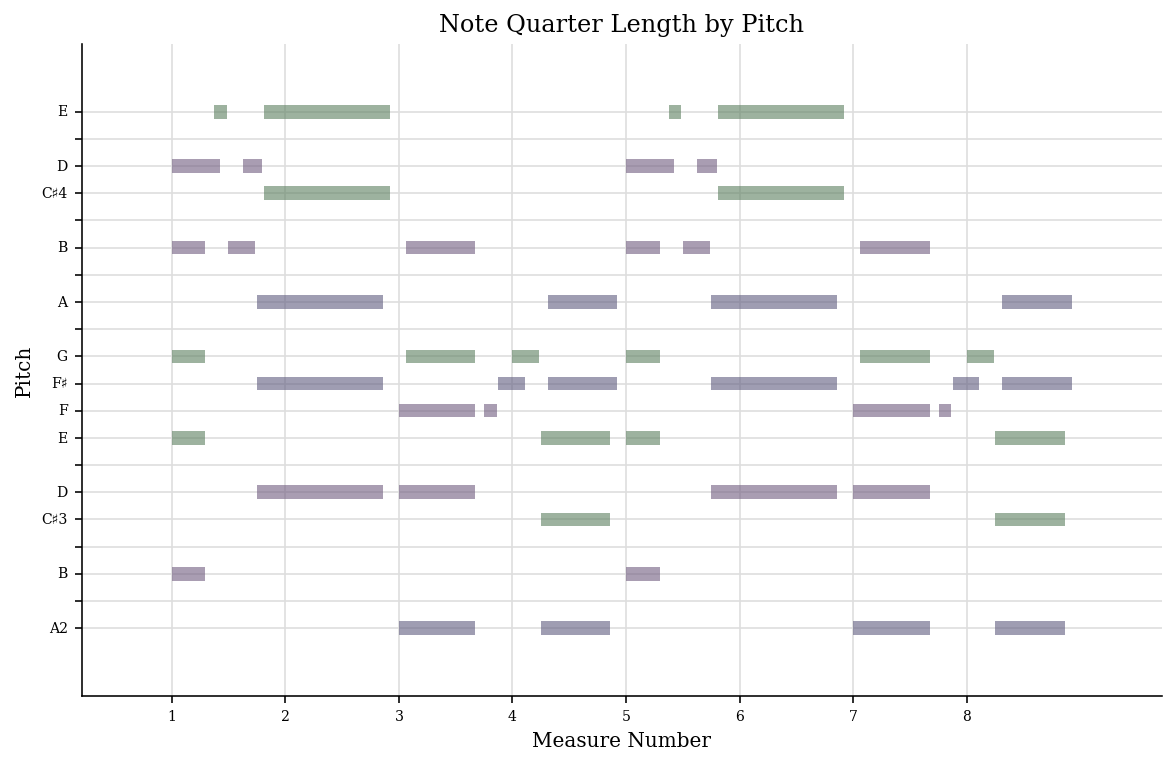

In [17]:
midi2 = converter.parse("lofi_songs/Cymatics - Lofi MIDI 22 - B Min.mid")
print(midi2)
midi2.plot()


<music21.graph.plot.HistogramPitchClass for <music21.stream.Score 0x216996977c0>>

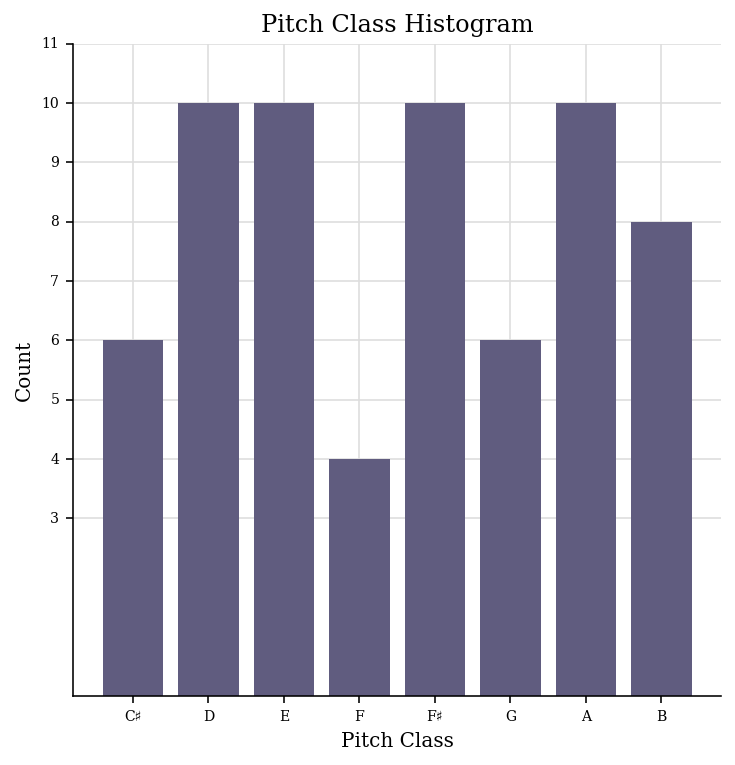

In [18]:
midi2.plot('histogram','pitchClass','count')

<music21.graph.plot.HorizontalBarPitchSpaceOffset for <music21.stream.Score 0x2169d260520>>

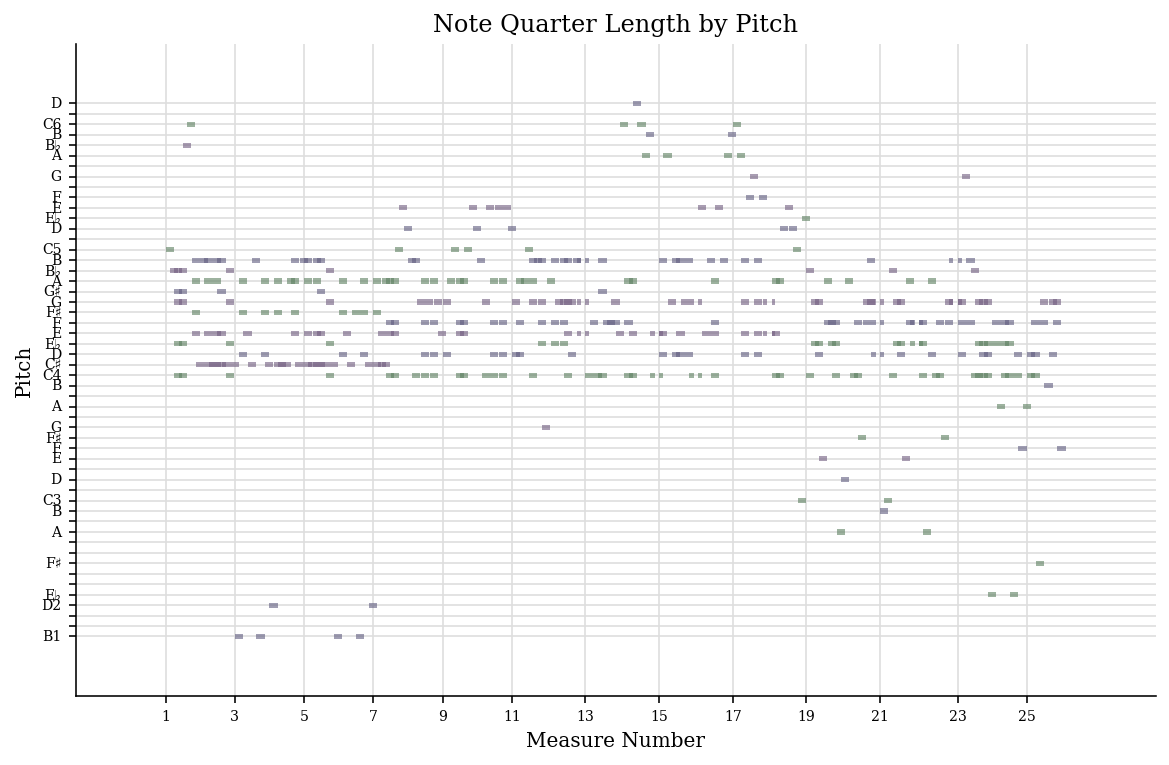

In [19]:
midi3 = converter.parse("outputs/lofi_midi_latest.mid")
midi3.plot()

<music21.graph.plot.HistogramPitchClass for <music21.stream.Score 0x2169d260520>>

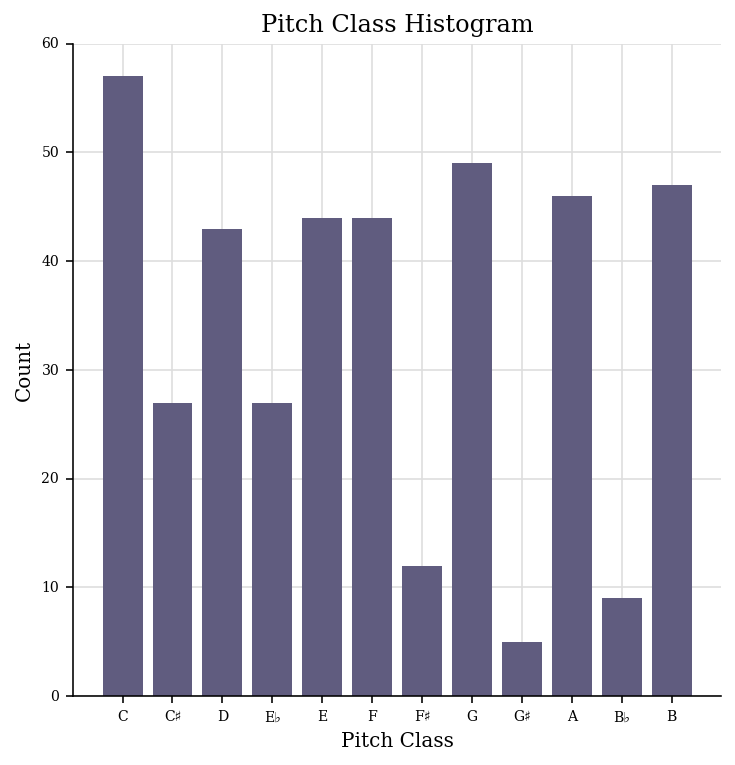

In [20]:
midi3.plot('histogram','pitchClass','count')

<music21.graph.plot.HorizontalBarPitchSpaceOffset for <music21.stream.Score 0x2169e633fd0>>

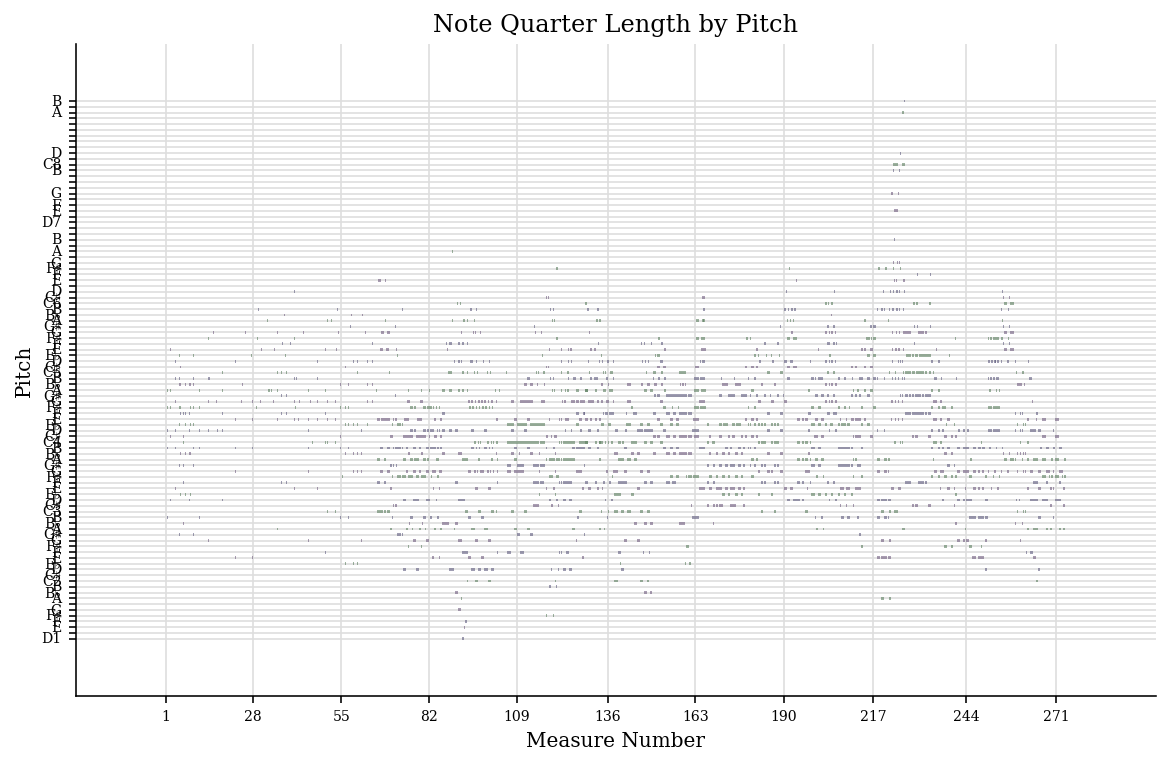

In [21]:
midi4 = converter.parse("gan_dataset_combined.mid")
midi4.plot()

<music21.graph.plot.HistogramPitchClass for <music21.stream.Score 0x2169e633fd0>>

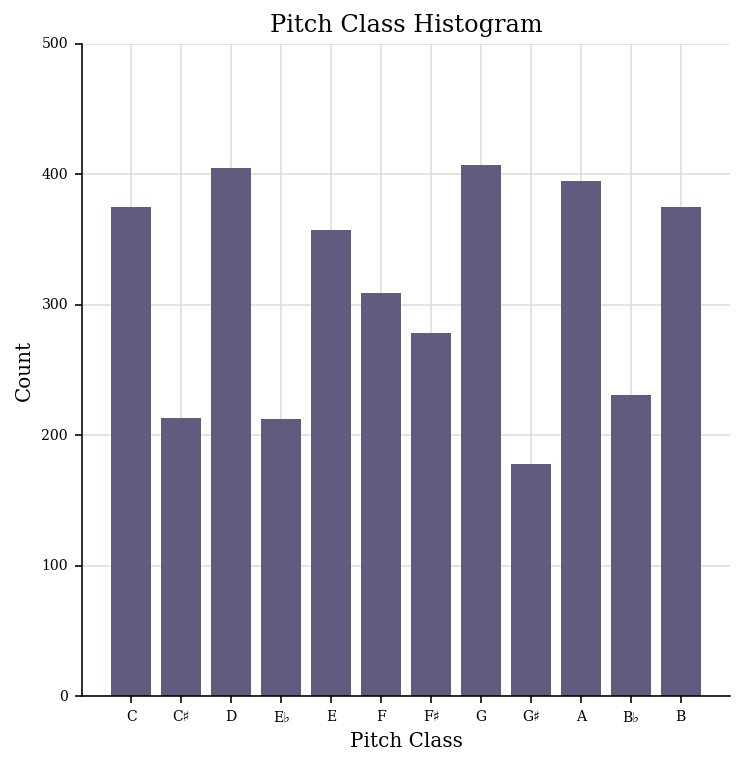

In [22]:
midi4.plot('histogram','pitchClass','count')

<music21.graph.plot.HorizontalBarPitchSpaceOffset for <music21.stream.Score 0x21699a90460>>

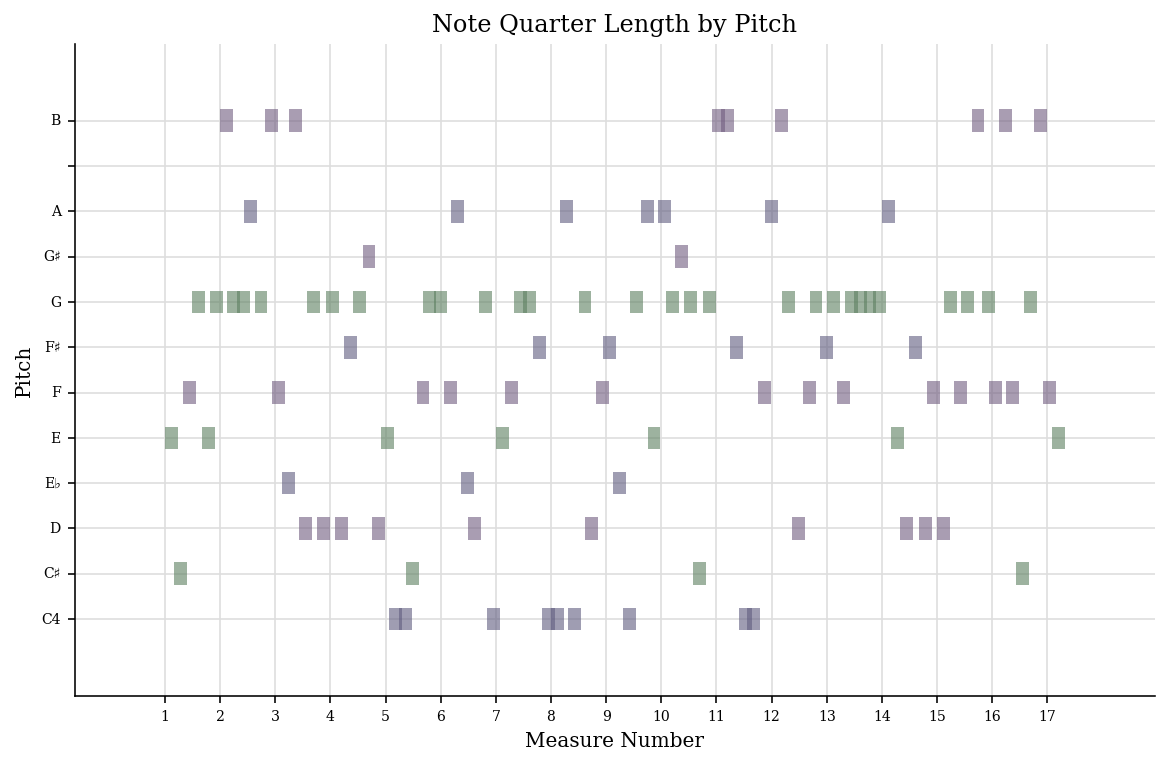

In [28]:
midi5 = converter.parse("gan_outputs/gan_output_lofi_new3_2k_2.mid")
midi5.plot()

<music21.graph.plot.HistogramPitchClass for <music21.stream.Score 0x2169da939a0>>

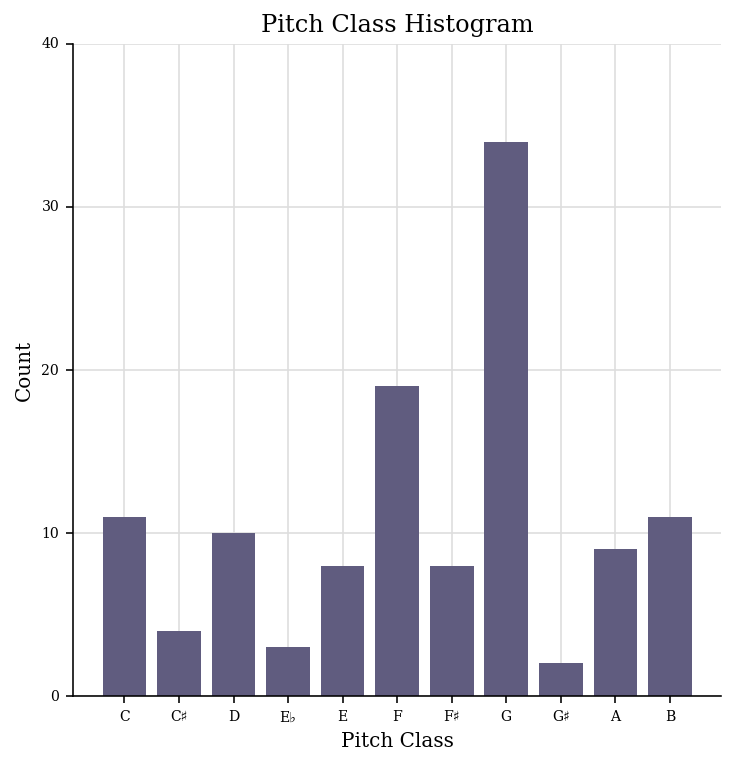

In [26]:
midi5.plot('histogram','pitchClass','count')

<music21.graph.plot.HorizontalBarPitchSpaceOffset for <music21.stream.Score 0x2169e4bb4c0>>

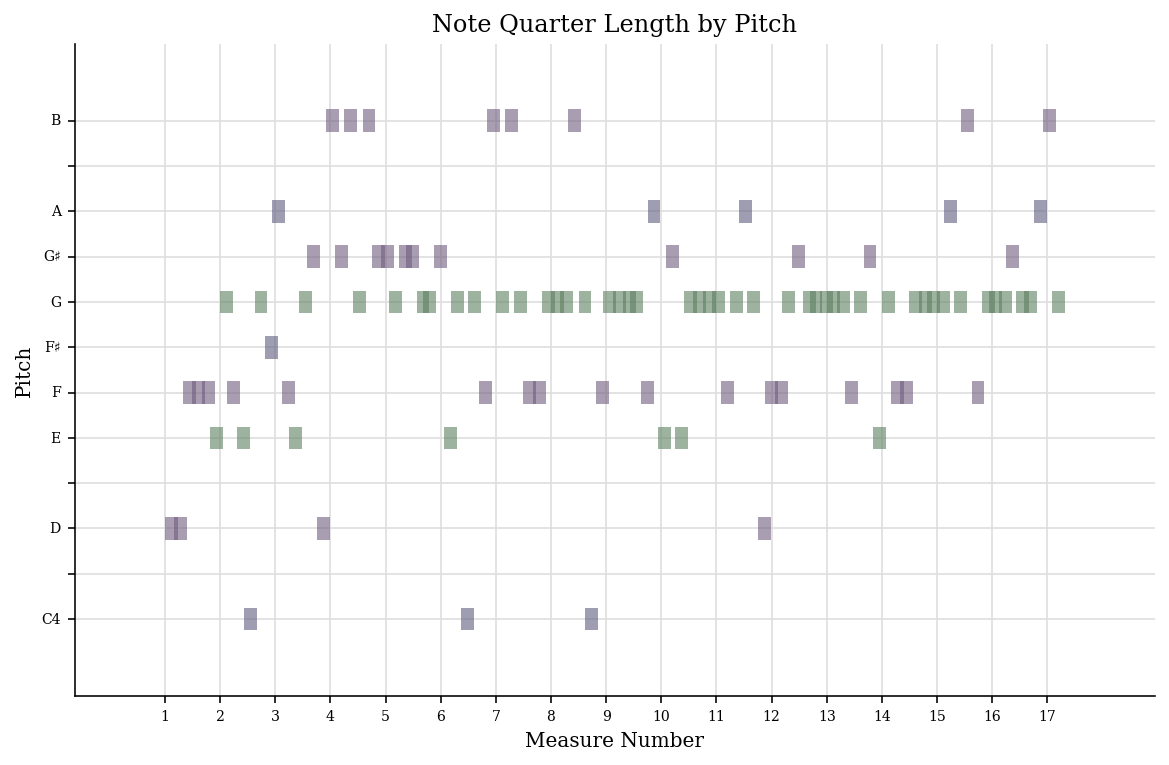

In [35]:
midi6 = converter.parse("gan_outputs/gan_output_lofi_RNN_10k_3.mid")
midi6.plot()

<music21.graph.plot.HistogramPitchClass for <music21.stream.Score 0x2169e4bb4c0>>

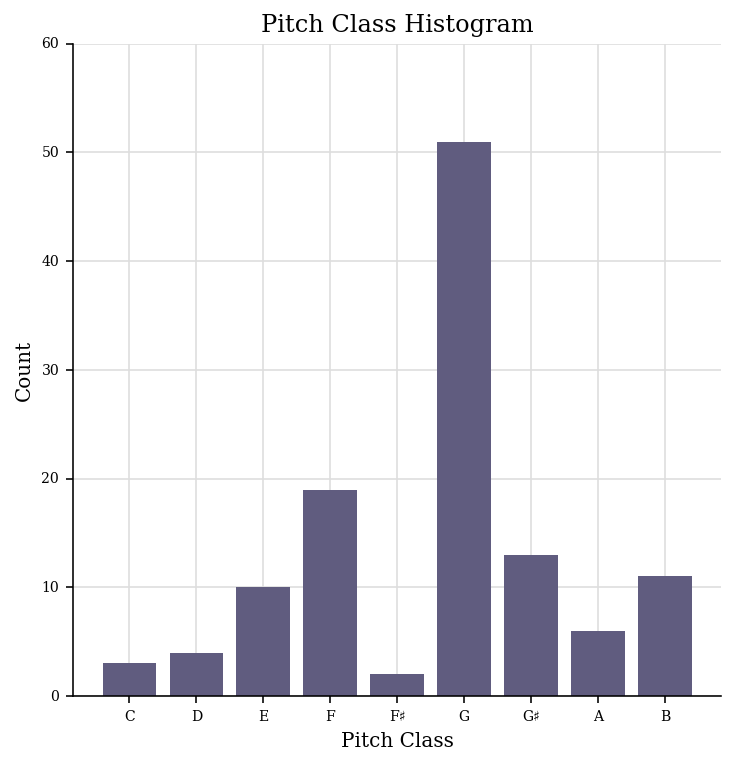

In [36]:
midi6.plot('histogram','pitchClass','count')